# Critical Mineral Screening tool
Module Overview:
1. Load and View Data
2. Run current model
3. Run a comparison between the maximum theoretical revenue with and without existing infrastructure
4. Identify the optimal location for desalination installation


In [12]:
## Imports
import pyomo.environ as pyo
from pareto.CM_module.models.qcp_br import build_qcp_br
from pareto.utilities.get_data import get_data
from pareto.utilities.cm_utils.gen_utils import report_results_to_excel
from pareto.utilities.cm_utils.opt_utils import (max_theoretical_recovery_flow,
                             max_theoretical_recovery_flow_opt,
                             cost_optimal,
                             max_recovery_with_infrastructure)
from pareto.utilities.cm_utils.run_utils import load_data, print_results_summary, solving, node_rerun
from pareto.utilities.cm_utils.data_parser import data_parser

from importlib import resources
from set_param_list import set_list, parameter_list

In [13]:
# Loading data
# In this problem we are going to use the toy case study
fname = 'small_case_study_Li'
with resources.path(
    "pareto.case_studies",
    "small_case_study_Li.xlsx",
) as fpath:
    # Obtaining data from excel file
    [df_sets, df_parameters] = get_data(fpath, set_list, parameter_list)

# Parsing the data to make it in the model format
data = data_parser(df_sets, df_parameters)

In [4]:
model = build_qcp_br(data)

# solving and displaying cost breakdown
model, _ = solving(model, tee=False)   # make tee=True if you want to see solver logs


Developing an initialization...

Solving bilinear problem...
Arc cost:                       4269
Disposal cost:               1103541
Freshwater cost:             5302452
Treatment cost:              1722170
Storage cost:                1755032
Storage revenue:             1737482
Treatment revenue:            513365
Net Beneficial Cost:         -513365
Total cost:                  7123253


This was the cost breakdown when we were to use the existing infrastructure. Now we will see whether our existing infrastrucutre is hindering or aiding the lithium recovery opportunities. 

In [5]:
max_inf_model = max_recovery_with_infrastructure(data)
print_results_summary(max_inf_model)

   ... running linear flow model
   ... running bilinear model
Max lithium revenue with existing infrastructure: 870608.1283921434
Arc cost:                      71087
Disposal cost:               1125289
Freshwater cost:             7770352
Treatment cost:              2250956
Storage cost:                 297742
Storage revenue:              202786
Treatment revenue:            870608
Net Beneficial Cost:         -870608
Total cost:                  9571422


In [6]:
max_recovery = max_theoretical_recovery_flow_opt(model, 
                                                 treatment_unit='R01_IN', # change R01 if you want to consider a different treatment unit
                                                 desired_li_conc=100)

# Displaying difference between max possible lithium revenue with and without existing infrastructure
print(f'Max. lithium revenue with\n existing infrastructure:  '
      f'{pyo.value(max_inf_model.treat_rev):>8.0f}')
print()
print(f'Max theoretical treatment revenue\n (ignoring infrastructure): '
      f'{max_recovery:>8.0f}')

Max. lithium revenue with
 existing infrastructure:    870608

Max theoretical treatment revenue
 (ignoring infrastructure):  1173483


As we can see the lithium revenue possible from this system is quite good and so infrastructure isn't a big hinderance to the lithium revenue opportunities

## Let's talk about infeasibility

There would be cases where the model would be infeasible. Let's see how the output would like in those cases.

Warning: This problem can take a long time to run. The small case study takes 8-10 mins and the large case study takes 20-25 mi

In [7]:
# We will change the minimum lithium concentration requirement to force infeasibility

print(data['p_Cmin'])

{('R01_CW', 'TDS'): 0, ('R01_CW', 'Li'): 100, ('R02_CW', 'TDS'): 0, ('R02_CW', 'Li'): 0}


In [8]:
data['p_Cmin']['R01_CW','Li'] = 150
print(data['p_Cmin'])

{('R01_CW', 'TDS'): 0, ('R01_CW', 'Li'): 150, ('R02_CW', 'TDS'): 0, ('R02_CW', 'Li'): 0}


In [9]:
model = build_qcp_br(data)

# solving and displaying cost breakdown
model, _ = solving(model, tee=False, inf_recs=True)   # make tee=True if you want to see solver logs


Developing an initialization...

Solving bilinear problem...
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
Model is Infeasible
                The model is infeasible. Some possible reasons for infeasibility: 
                 1. The minimum CM recovery concentration is too high given the existing infrastructure and parameters 
                 2. The produced water concentration is too low to meet minimum CM concentration requirements 
                 3. The treatment efficiency is not sufficient to meet the minimum CM concentration 
                 4. Installation of pipelines for direct transportation of water from high CM concentration production pads to desalination sites would aid feasibility 
                 


## Optimal Treatment Facility Location
What if we want to see which node within the network is the best location for installing the treatment facility?

In the next 





making new models

model N01 being made...
model N02 being made...
model N03 being made...
model N04 being made...
model N05 being made...
model N06 being made...
model N07 being made...
model N08 being made...
model N09 being made...

models generated





Running N01


Developing an initialization...

Solving bilinear problem...
Arc cost:                      19407
Disposal cost:               1244530
Freshwater cost:             5486930
Treatment cost:              1566877
Storage cost:                1632047
Storage revenue:             1615726
Treatment revenue:            463546
Net Beneficial Cost:         -463546
Total cost:                  7406972


Running N02


Developing an initialization...

Solving bilinear problem...
Arc cost:                       9530
Disposal cost:               1244530
Freshwater cost:             5486930
Treatment cost:              1566877
Storage cost:                1632047
Storage revenue:             1615726
Treatment revenue:            46

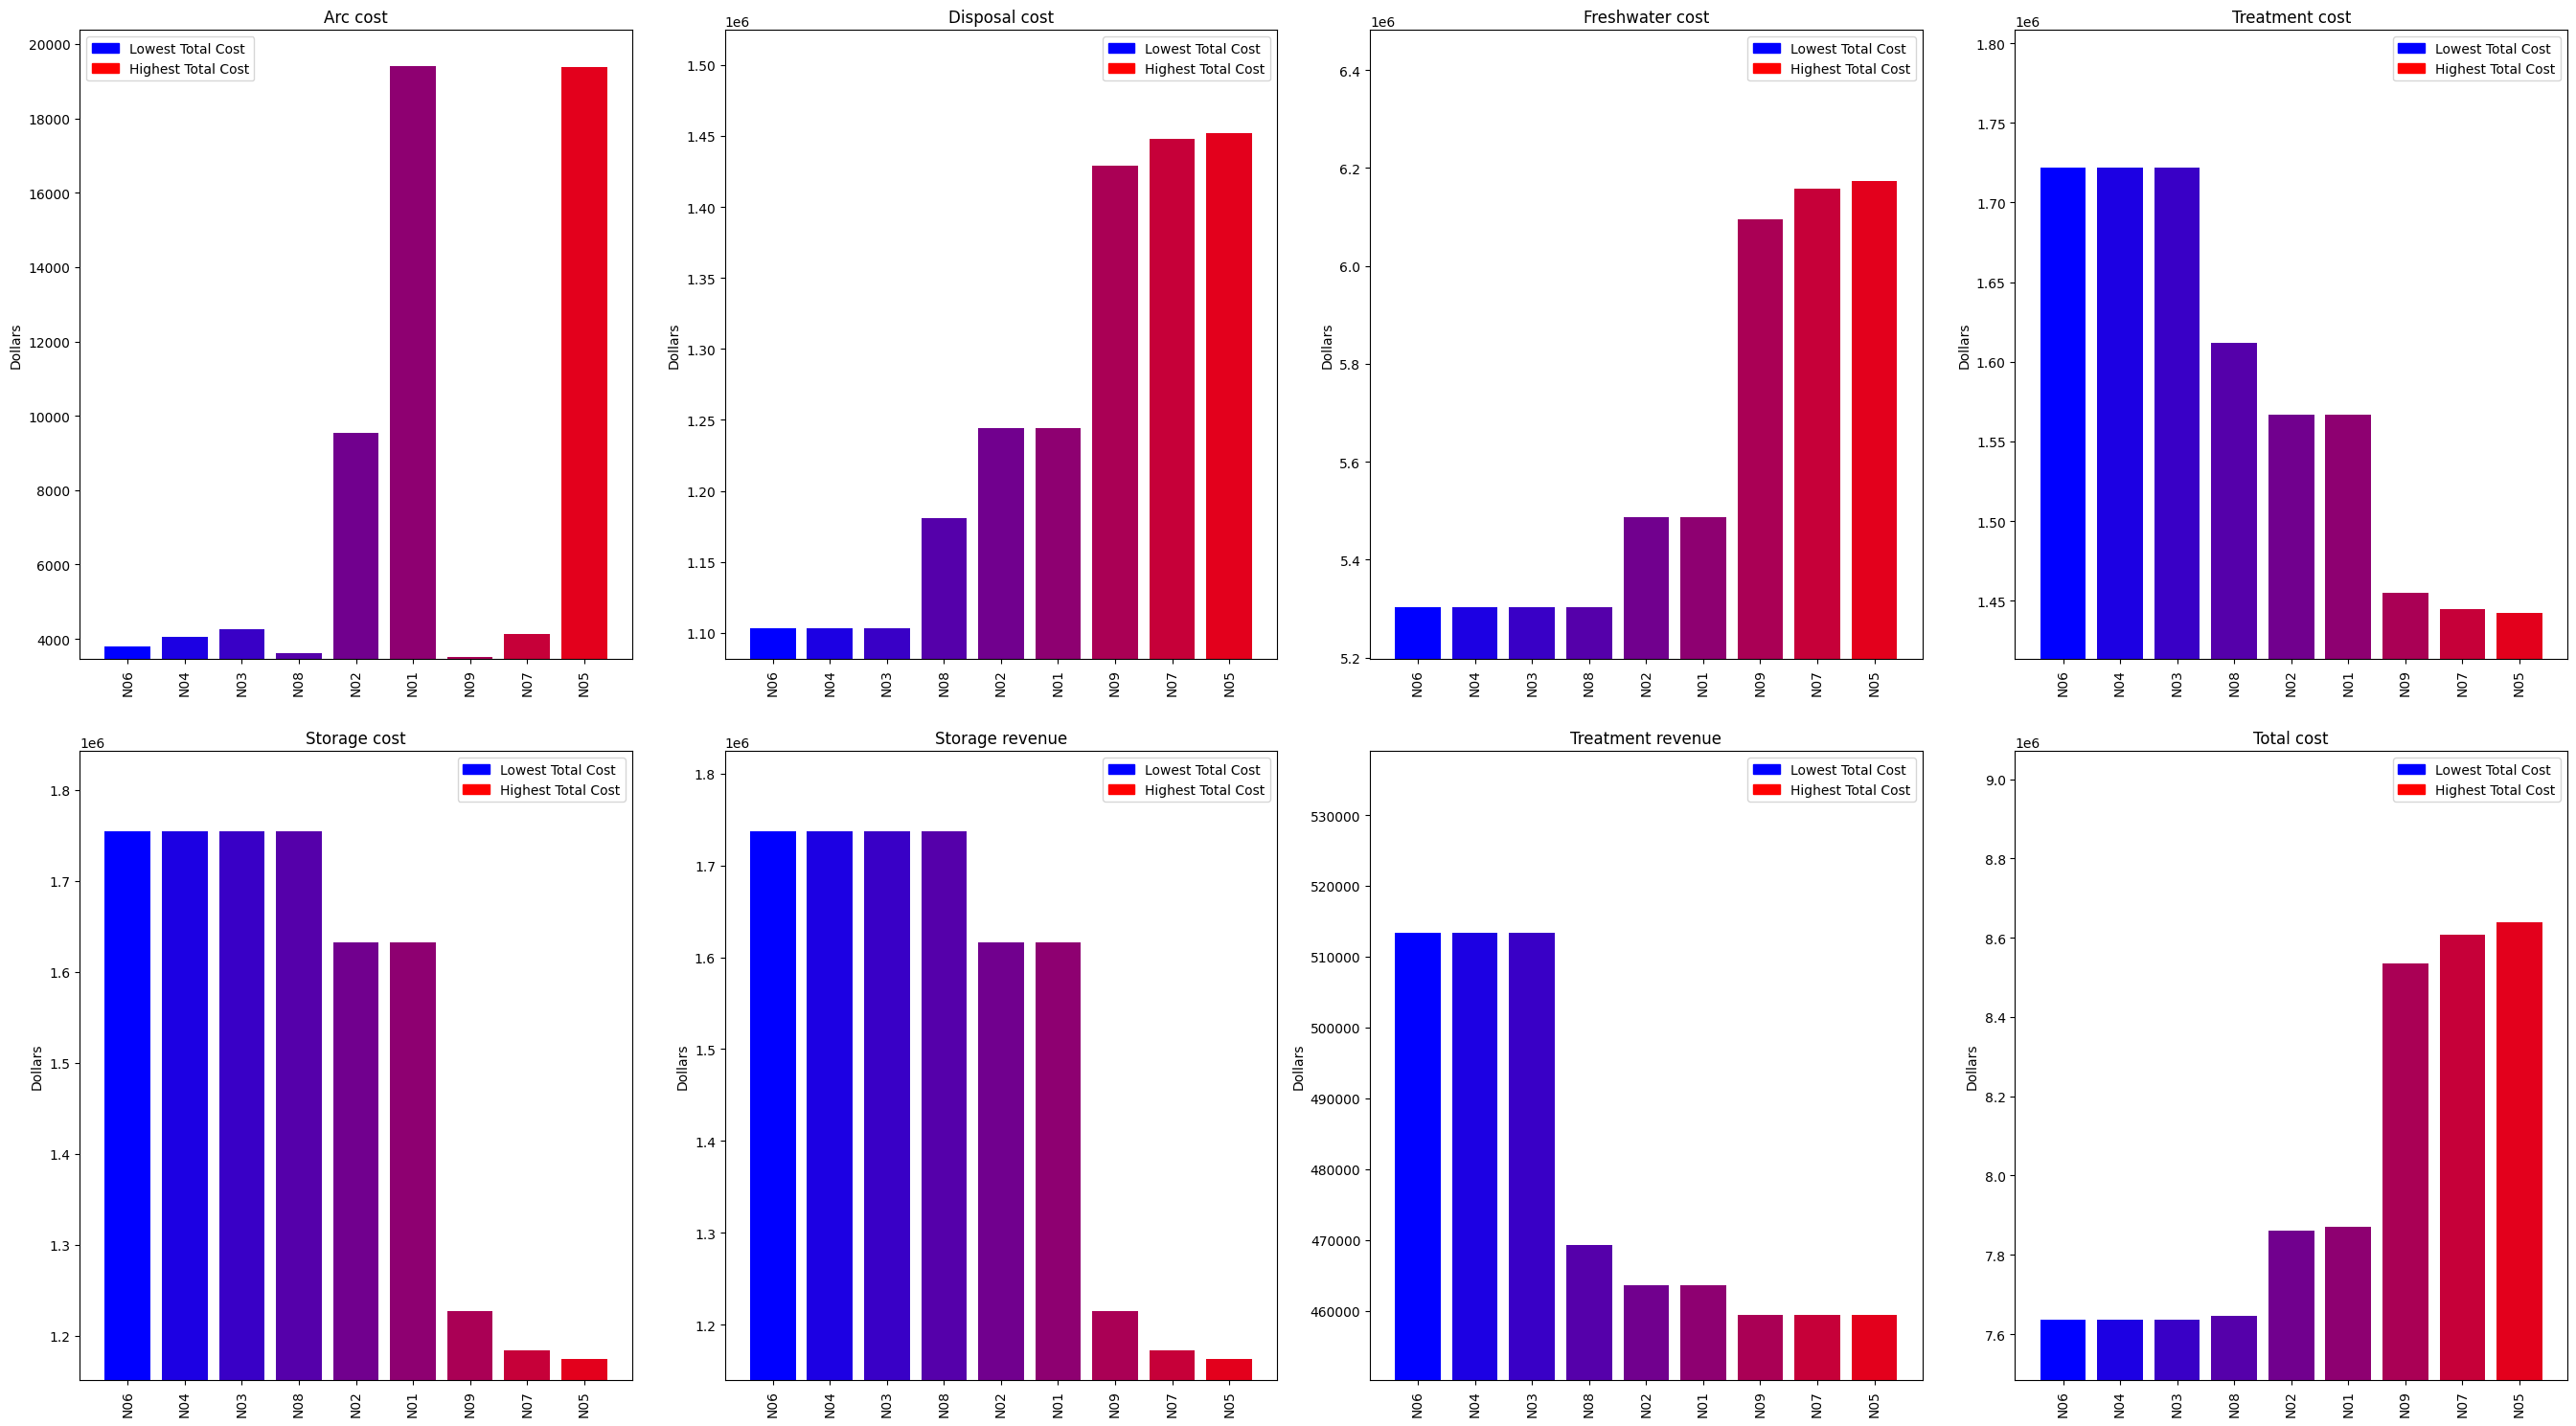


Node N06 had the smallest total cost, which amounted to 7636154.942932557.

*** Lowest cost location for treatment ***
Arc cost:                       3806
Disposal cost:               1103541
Freshwater cost:             5302452
Treatment cost:              1722170
Storage cost:                1755032
Storage revenue:             1737482
Treatment revenue:            513365
Net Beneficial Cost:         -513365
Total cost:                  7122790


In [14]:
min_node, models = node_rerun(df_sets, df_parameters, treatment_site='R01', max_iterations=5000)
final_model = models[min_node]
print()
print(f'*** Lowest cost location for treatment ***')

# Displaying specific broken down costs
print_results_summary(final_model)